In [1]:
import sys
import os
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm

sys.path.append("../../src")
from losses import LinearClassification
from block_analysis import block_hessian, curvature_effects, eval_loss, update_params
from lr_tools import lr_calibrate
from models import conv_net
from data import gen_cifar10_ds

## helpers

### Investigation:

- Different LR
- More granular observations
- GD vs SGD

## params

In [4]:
inp_dim = 3
hid_dim = 64
out_dim = 10
nlayer = 5
bias = False
use_bn = False
mode = "relu"
loss_mode = 'CrossEntropy'
device = 0

nsamp = 500

save_model_dir = "models"

### Analysis

In [6]:
from utils import zero_grad
from activation_stats import first_order_analysis, plot_param, plot_activ
from block_analysis import clone_model, eval_loss

In [ ]:
def get_model_ds_loss(loss_mode='CrossEntropy'):    
    model =  conv_net(inp_dim, hid_dim, out_dim, nlayer, bias, use_bn, mode).cuda(device)
    ds = gen_cifar10_ds(nsamp, device)
    
    assert loss_mode in ["CrossEntropy", "Linear"]
    if loss_mode=='CrossEntropy':
        loss_fn = nn.CrossEntropyLoss()
    elif loss_mode=='Linear':
        loss_fn = LinearClassification(out_dim)
        
    return model, ds, loss_fn

def correct(classifier, target):
    return classifier.max(dim = 1)[1] == target

def train_epoch(model, ds, loss_fn, lr):
    zero_grad(model)
    loss = eval_loss(model, ds, loss_fn)

    grads = [x.grad for x in model.parameters()]
    delta = grads#get_delta_params(model, grads)
    params = list(model.parameters())
    
    update_params(params, delta, lr)

    #delta_norm = list(map(lambda x: x.clone().norm().item(), delta))
    model.zero_grad()
    
    acc = correct(model(ds[0][0]), ds[0][1])

    return loss, acc.type(torch.FloatTensor).mean().item() #delta_norm, 

In [ ]:
import pandas as pd

def relative_error(a, b, eps=1e-6):
    """
    """
    return abs((a - b) / min(abs(a), abs(b)))

def init_dir(path, name="default"):
    path = f"{save_model_dir}/{name}/"
    if not os.path.exists(path):
        os.makedirs(path)
        
def save_model(model, epoch, name="default"):
    torch.save(model.state_dict(), f"{save_model_dir}/{name}/{epoch}.pth".format(save_model_dir, epoch))

def select(stats, column):
    """
    """
    stats = [stat[column]for stat in stats]
    return pd.concat(stats, axis=1).T.set_index(np.arange(len(stats)))

def plot_stats(stats, column, *args, ax=None, **kwargs):
    """
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(12,8))
    df = select(stats, column)
    df.plot(*args, ax=ax, **kwargs)
    
def summarize_stats(stats):
    """
    """
    fig, ax = plt.subplots(2,2, figsize=(20, 20))
    plot_stats(stats, 'a_l_std', ax=ax[0,0])
    plot_stats(stats, 'a_l_m', ax=ax[0,1])
    plot_stats(stats, 'W_g_std', ax=ax[1,0])
    plot_stats(stats, 'W_std', ax=ax[1,1])
    
def run_analysis(model, ds, loss_fn, lr, epochs, valfreq=40):
    """
    """
    init_dir(save_model_dir)
    val_stats, tr_stats = [],[]

    for epoch in tqdm(range(epochs)):
        if (epoch+1) % valfreq==0:
            H = block_hessian(model, ds, loss_fn, lr)
            delta, fo, ho, fostat = first_order_analysis(model, ds, loss_fn, lr)
            error = relative_error(H.sum().item(), ho)
            val_stats.append((H, delta, fo, ho, error, fostat))
            save_model(model, epoch)

        loss, acc = train_epoch(model, ds, loss_fn, lr)
        tr_stats.append((loss, acc))

    H, delta, fo, ho, error, fostat = list(zip(*val_stats))
    loss, acc = list(zip(*tr_stats))
    
def plot_acc_loss(acc, loss, ax=None):
    """
    """
    if ax is None:
        fig, ax = plt.subplots(1,2, figsize=(12,5))
    ax[1].plot(loss)
    ax[0].plot(acc)

In [34]:
epochs = 2000
lr = 0.01
valfreq = 40

model, ds, loss_fn = get_model_ds_loss(loss_mode)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
run_analysis(model, ds, loss_fn, lr, epochs, valfreq)

In [ ]:
plot_acc_loss(acc, loss)

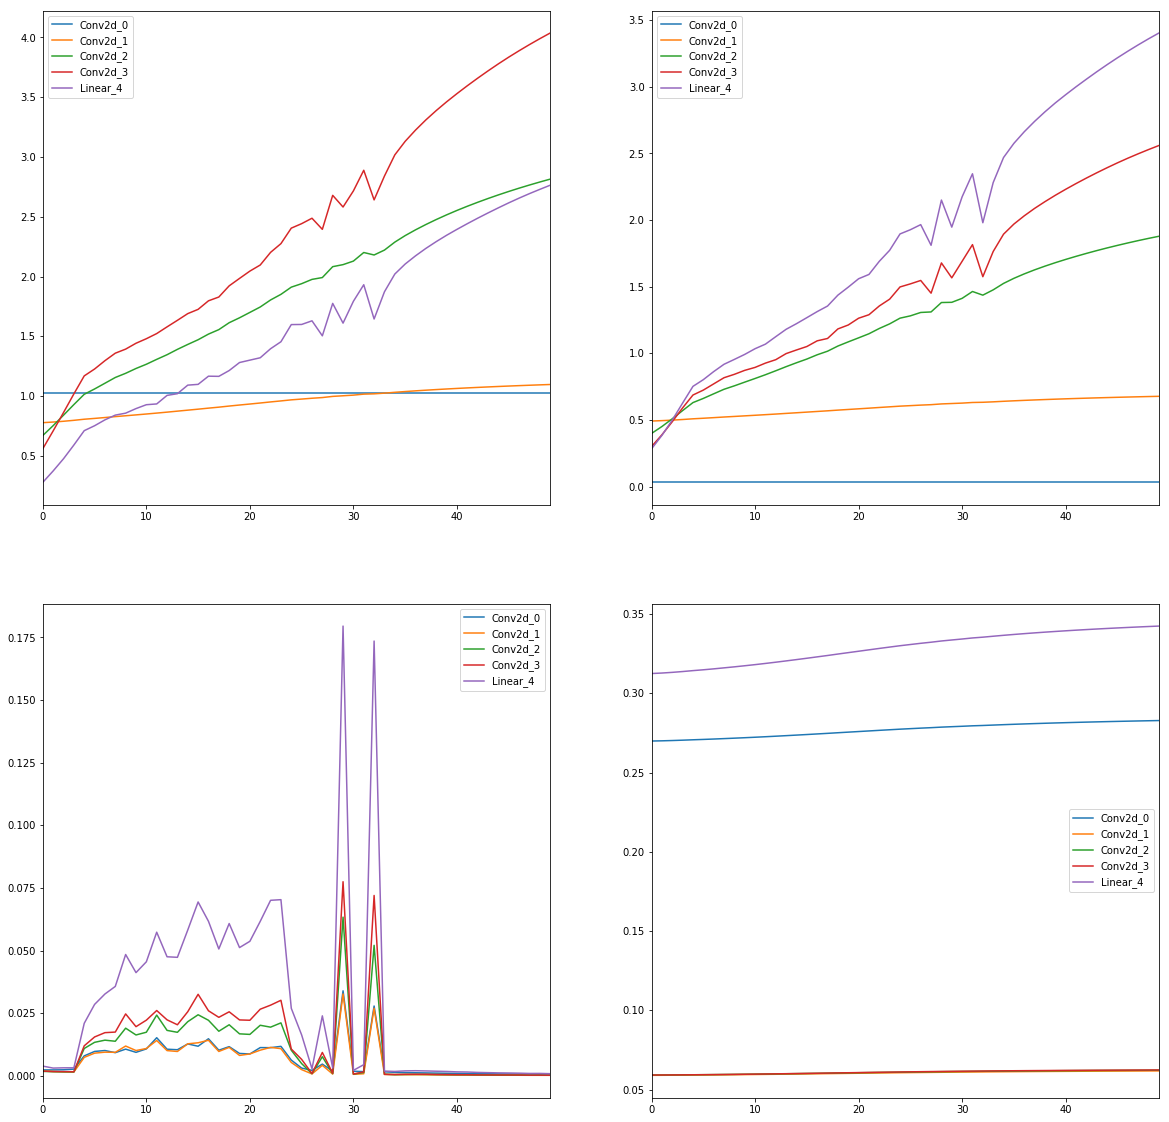

In [33]:
summarize_stats(stats)